# Dynamic Time Warping (DTW)-based Morris GSA for Dynamical Systems

This is to accompany the paper:

"Fortela, D. L.; Mikolajczyk, A.; Hernandez, R.; Revellame, E.; Sharp, W.; Holmes, W.; Zappi, M. E. Dynamic Time Warping as Elementary Effects Metric for Morris-based Global Sensitivity Analysis of High-dimension Dynamical Models. Preprints 2024, 2024100502. https://doi.org/10.20944/preprints202410.0502.v1"

## Preliminaries

Import the required Python packages:

Run Environemnt Rquirements:
- Python 3.11
- numpy >=2.1.3
- matplotlib >= 3.9.2
- scipy >= 1.9.3
- salib >= 1.4.7 (within the DTWMorrisGSA package)
- fastdtw >= 0.3.4 (within the DTWMorrisGSA package)



In [1]:
# import installed Python package
import numpy as np
import random
import csv
from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt

import scipy.spatial.distance as dist # to compute distance
from scipy.integrate import solve_ivp # to integrate the ODE's
from scipy.stats import rankdata # to rank the GSA index data


In [3]:
# Install and import the DTWMorrisGSA module from PyPi - this is the Python script created for the paper
# note: there seems to be a required space " " character before DTWMorrisGSA
!pip install -i https://test.pypi.org/simple/ DTWMorrisGSA

import DTWMorrisGSA as morris_method 


Looking in indexes: https://test.pypi.org/simple/
  Using cached https://test-files.pythonhosted.org/packages/c3/db/5e987646565f9ea977da4dd19733bac5587196cab8bbec429ca0706a5892/DTWMorrisGSA-0.1.1-py3-none-any.whl.metadata (929 bytes)
Using cached https://test-files.pythonhosted.org/packages/c3/db/5e987646565f9ea977da4dd19733bac5587196cab8bbec429ca0706a5892/DTWMorrisGSA-0.1.1-py3-none-any.whl (13 kB)


## Figure 1 - Illustration on how DTW computes the cost of alignment

Use Univariate example for easy visualization:

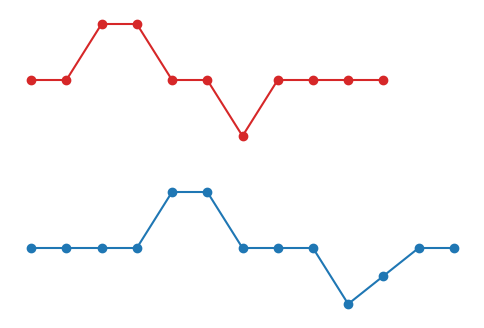

In [3]:
# create data
x = np.array([0, 0, 1, 1, 0, 0, -1, 0, 0, 0, 0])
y = np.array([0, 0, 0, 0, 1, 1, 0, 0, 0, -1, -0.5, 0, 0])

savefig_options = dict(format="png", dpi=300, bbox_inches="tight")
plt.figure(figsize=(6, 4))
plt.plot(np.arange(x.shape[0]), x + 1.5, "-o", c="C3")
plt.plot(np.arange(y.shape[0]), y - 1.5, "-o", c="C0")
plt.axis("off")
#plt.savefig('fig1_sample_univar.png', dpi=300)
plt.show()


Alignment cost: 0.5000
Normalized alignment cost: 0.0208


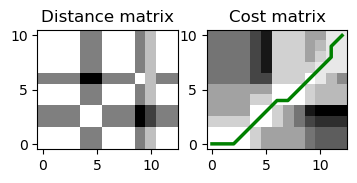

In [4]:
# Distance matrix
N = x.shape[0]
M = y.shape[0]
dist_mat = np.zeros((N, M))
for i in range(N):
    for j in range(M):
        dist_mat[i, j] = abs(x[i] - y[j])


# DTW
path, cost_mat = morris_method.dp(dist_mat)
print("Alignment cost: {:.4f}".format(cost_mat[N - 1, M - 1]))
print("Normalized alignment cost: {:.4f}".format(cost_mat[N - 1, M - 1]/(N + M)))
# plot and save
savefig_options = dict(format="png", dpi=300, bbox_inches="tight")

plt.figure(figsize=(4, 2))
plt.subplot(121)
plt.title("Distance matrix")
plt.imshow(dist_mat, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
plt.subplot(122)
plt.title("Cost matrix")
plt.imshow(cost_mat, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
x_path, y_path = zip(*path)
plt.plot(y_path, x_path, color = 'green', linewidth= 2.5);
#plt.savefig("fig1_sample_univar_CostMAT.png", **savefig_options)
plt.show()


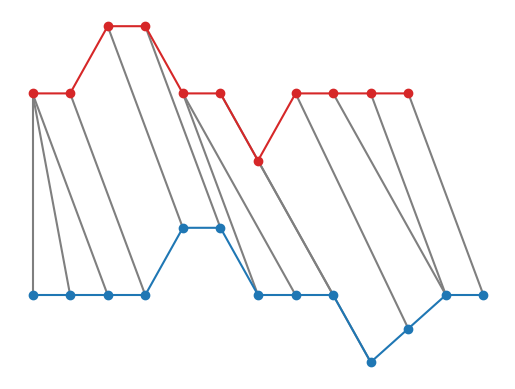

In [5]:
# Plot aligned curves
savefig_options = dict(format="png", dpi=300, bbox_inches="tight")
plt.figure()
for x_i, y_j in path:
    plt.plot([x_i, y_j], [x[x_i] + 1.5, y[y_j] - 1.5], c="C7")
plt.plot(np.arange(x.shape[0]), x + 1.5, "-o", c="C3")
plt.plot(np.arange(y.shape[0]), y - 1.5, "-o", c="C0")
plt.axis("off")
#plt.savefig("fig1_sample_univar_Aligned.png", **savefig_options)
plt.show()



## Paper Example 1 - Adsorption Kinetics

This is a univariate exmaple with multiple model parameters

### Perform the DTW-based Morris GSA

In [11]:
# create RNG seed index:

# Python code to generate
# random numbers and
# append them to a list

# Function to generate
# and append them 
# start = starting range,
# end = ending range
# num = number of 
# elements needs to be appended
def Rand(start, end, num):
	res = []

	for j in range(num):
		res.append(random.randint(start, end))

	return res

# Driver Code - generate SEED
num = 10 # = Number of DTW Morris GSA Calc. Loops; SET THiS TO HIGHER levels for or best colleciton of data
start = 7
end = 9000
SEED = Rand(start, end, num)

# for loop on the RNG seed
report_with_seed = [] # initiate empty list of results 
loop = 0

for seed in SEED:
    
    loop+=1
    print(f'Loop: {loop}')
    print(f'Seed: {seed}')
    
    
    np.random.seed(seed=seed)
    npara = 3
    x0    = np.ones(npara)*0.5
    # params: k1, k2, qe
    lb = np.array([0.00, 0.00, 0.1])
    ub = np.array([0.2, 23, 100])
    
    mask  = np.ones(npara, dtype=bool)
    nmask = np.sum(mask)
    nt     = npara*15
    ntotal = max(nt**2, 10*nt)
    nsteps = 30 # steps per parameter
    tmatrix, tvec = morris_method.morris_sampling(nmask, lb[mask], ub[mask], nt,
                                     nsteps=nsteps, ntotal=None,
                                     Diagnostic=True)
    
    # Set input vector to trajectories and masked elements to x0
    param_values = np.tile(x0, tvec.size).reshape(tvec.size, npara)  # default to x0
    param_values[:,mask] = tmatrix  # replaced unmasked with trajectorie values
    print(f'Example param values top-row: \n {param_values[0,:]}')
    
    
    # show size of sampled parameters array
    print(f'Shape of model output: \n {param_values.shape}')
    

    ####################################------------------
    ######- Evaluate the ODE model
    #
    # use a dynamical model toy example
    # also, take only the last y-value as final output (not the time-series) for simplicity for now
    
    # import scipy to integrate ODEs
    from scipy.integrate import solve_ivp
    
    # initialize Y array
    Y = []
    
    # loop over ingetrating IVP ODE system
    for i, x in enumerate(param_values):
        
        def rhs(s, v): #s is time and v is output var of ODE
            k1 = x[0]
            k2 = x[1]
            qe = x[2]

            dv1 = k1*(qe-v[0])+k2*(qe-v[0])**2
            
            return [dv1]
            
        t_eval = np.linspace(0, 50, 100)
        res = solve_ivp(rhs, [0, 50] , [0], t_eval=t_eval)
        Y.append(res.y.reshape(1,res.t.shape[0]))
    
    # convert list to numpy array
    fx2 = np.array(Y)

    # Normalize the values in the 3D array
    # Normalize along 2nd-Dim (hence axis=1)
    fx2_dim2_l1 = fx2[:,0,:]
    max_dim2_l1 = np.max(fx2_dim2_l1, keepdims=True)
    min_dim2_l1 = np.min(fx2_dim2_l1, keepdims=True)
    fx2_norm_dim2_l1 = (fx2_dim2_l1-min_dim2_l1) / (max_dim2_l1-min_dim2_l1)
    fx2_norm_dim2_l1 = np.reshape(fx2_norm_dim2_l1, (fx2.shape[0],1,fx2.shape[2]))
    fx2_norm = fx2_norm_dim2_l1

    ######################-------------
    ######-
    # now compute the GSA indices using the normalized output values
    sa, res = morris_method.elementary_effects(nmask, tmatrix, tvec, fx2_norm, nsteps=nsteps,
                                 Diagnostic=False, metric='euclidean')

    # rank params based on mu:
    ranks = rankdata(res[:,0], method='ordinal')

    # store results
    report = np.concatenate((res[:,(0,2)], np.reshape(ranks,(-1,1))), axis=1)
    
    # combine results 
    report_with_seed.append(np.c_[np.repeat(seed, report.shape[0]),report])


    ######################-------------
    # save the results as CSV file
    # include in the for-loop to save at ever seed and as CSV expands

    # Specify the filename
    filename = "my_data5_p23_AdsorptionMixedOrder_50min.csv"
    # Writing to the csv file
    with open(filename, 'w', newline='') as csvfile:
        # Create a writer object from csv module
        csvwriter = csv.writer(csvfile)

        # Writing the data into the file
        for row in report_with_seed:
            csvwriter.writerow(row)


######################-------------




Loop: 1
Seed: 310
Example param values top-row: 
 [ 0.          7.13793103 41.43793103]
Shape of model output: 
 (180, 3)
Loop: 2
Seed: 7196
Example param values top-row: 
 [8.96551724e-02 1.26896552e+01 9.65551724e+01]
Shape of model output: 
 (180, 3)
Loop: 3
Seed: 6016
Example param values top-row: 
 [ 0.11724138 12.68965517  3.54482759]
Shape of model output: 
 (180, 3)
Loop: 4
Seed: 4916
Example param values top-row: 
 [ 0.         22.20689655 58.66206897]
Shape of model output: 
 (180, 3)
Loop: 5
Seed: 5755
Example param values top-row: 
 [ 0.09655172 22.20689655  3.54482759]
Shape of model output: 
 (180, 3)
Loop: 6
Seed: 4388
Example param values top-row: 
 [ 0.         11.89655172 34.54827586]
Shape of model output: 
 (180, 3)
Loop: 7
Seed: 8220
Example param values top-row: 
 [ 0.11034483  0.79310345 51.77241379]
Shape of model output: 
 (180, 3)
Loop: 8
Seed: 384
Example param values top-row: 
 [ 0.19310345 23.         62.10689655]
Shape of model output: 
 (180, 3)
Loop: 9
S

## Paper Example 2 - Microbial Kinetics

This is a mulitple outputs and multiple parameters model analys using a Monod-type kinetics. 

### Perform the DTW-based Morris GSA

In [12]:
# create RNG seed index:

# Python code to generate
# random numbers and
# append them to a list
import random

# Function to generate
# and append them 
# start = starting range,
# end = ending range
# num = number of 
# elements needs to be appended
def Rand(start, end, num):
	res = []

	for j in range(num):
		res.append(random.randint(start, end))

	return res

# Driver Code - generate SEED
num = 10 # = Number of DTW Morris GSA Calc. Loops; SET THiS TO HIGHER levels for or best colleciton of data
start = 1
end = 1000
SEED = Rand(start, end, num)

# for loop on the RNG seed


report_with_seed = [] # initiate empty list of results 

for seed in SEED:

    print(f'Seed: {seed}')
    
    
    np.random.seed(seed=seed)
    
    npara = 6
    x0    = np.ones(npara)*0.5

    # set model parameters lower and upper bounds sampling
    lb = np.array([0.03, 10, 4, 0.5, 0.01, 0.5])
    ub = np.array([0.05, 14, 6, 2.0, 0.10, 1.0])
    
    mask  = np.ones(npara, dtype=bool)
    nmask = np.sum(mask)
    nt     = npara*15
    ntotal = max(nt**2, 10*nt)
    nsteps = 30 # steps per parameter
    tmatrix, tvec = morris_method.morris_sampling(nmask, lb[mask], ub[mask], nt,
                                     nsteps=nsteps, ntotal=None,
                                     Diagnostic=True)
    
    # Set input vector to trajectories and masked elements to x0
    param_values = np.tile(x0, tvec.size).reshape(tvec.size, npara)  # default to x0
    param_values[:,mask] = tmatrix  # replaced unmasked with trajectorie values
    print(f'Example param values top-row: \n {param_values[0,:]}')
    
    
    # show size of sampled parameters array
    print(f'Shape of model output: \n {param_values.shape}')
    
    
    
    ####################################------------------
    
    ######- Evaluate the ODE model
    #
    # use a dynamical model toy example
    # also, take only the last y-value as final output (not the time-series) for simplicity for now
    
    # import scipy to integrate ODEs
    from scipy.integrate import solve_ivp
    
    # initialize Y array
    Y = []
    
    # loop over ingetrating IVP ODE system
    for i, x in enumerate(param_values):
        
        def rhs(s, v): #s is time and v is output var of ODE
            kd = x[0]
            Ysc = x[1]
            Ypc = x[2]
            Ks = x[3]
            m = x[4]
            umax = x[5] 
            
            kobs = (umax*(1-v[2]/93)**0.52)
            rg = kobs*v[0]*v[1]/(Ks+v[1])
            rd = v[0]*kd
            rsm = m*v[0]
            
            dv1 = rg - rd # Cc
            dv2 = Ysc*(-rg) - rsm # Cs
            dv3 = Ypc*rg # Cp
               
            return [dv1, dv2, dv3]
            
        t_eval = np.linspace(0, 100, 100)
        res = solve_ivp(rhs, [0, 100] , [2, 10, 0.00], t_eval=t_eval)
        Y.append(res.y.reshape(3,res.t.shape[0]))
    
    # convert list to numpy array
    fx2 = np.array(Y)

    # Normalize the values in the 3D array
    # Normalize along 2nd-Dim (hence axis=1)
    fx2_dim2_l1 = fx2[:,0,:]
    max_dim2_l1 = np.max(fx2_dim2_l1, keepdims=True)
    min_dim2_l1 = np.min(fx2_dim2_l1, keepdims=True)
    fx2_norm_dim2_l1 = (fx2_dim2_l1-min_dim2_l1) / (max_dim2_l1-min_dim2_l1)
    fx2_norm_dim2_l1 = np.reshape(fx2_norm_dim2_l1, (fx2.shape[0],1,fx2.shape[2]))

    fx2_dim2_l2 = fx2[:,1,:]
    max_dim2_l2 = np.max(fx2_dim2_l2, keepdims=True)
    min_dim2_l2 = np.min(fx2_dim2_l2, keepdims=True)
    fx2_norm_dim2_l2 = (fx2_dim2_l2-min_dim2_l2) / (max_dim2_l2-min_dim2_l2)
    fx2_norm_dim2_l2 = np.reshape(fx2_norm_dim2_l2, (fx2.shape[0],1,fx2.shape[2]))

    fx2_dim2_l3 = fx2[:,2,:]
    max_dim2_l3 = np.max(fx2_dim2_l3, keepdims=True)
    min_dim2_l3 = np.min(fx2_dim2_l3, keepdims=True)
    fx2_norm_dim2_l3 = (fx2_dim2_l3-min_dim2_l3) / (max_dim2_l3-min_dim2_l3)
    fx2_norm_dim2_l3 = np.reshape(fx2_norm_dim2_l3, (fx2.shape[0],1,fx2.shape[2]))

    # concatenate each 2nd-Dim slice
    fx2_norm = np.concatenate((fx2_norm_dim2_l1, fx2_norm_dim2_l2,fx2_norm_dim2_l3), axis=1)


    
    ######################-------------

    ######-
    # now compute the GSA indices using the normalized output values
    sa, res = morris_method.elementary_effects(nmask, tmatrix, tvec, fx2_norm, nsteps=nsteps,
                                 Diagnostic=False, metric='euclidean')

    
    #print(f'SA (individual sensitivity measures): \n{sa}')
    #print(f'Res (Mu*, Mu Stdev): \n{res}')
    
    
    
    # rank params based on mu:

    ranks = rankdata(res[:,0], method='ordinal')

    # store results
    report = np.concatenate((res[:,(0,2)], np.reshape(ranks,(-1,1))), axis=1)
    
    # combine results 
    report_with_seed.append(np.c_[np.repeat(seed, report.shape[0]),report])


    ######################-------------
    # save the results as CSV file
    # include in the for-loop to save at ever seed and as CSV expands

    # Specify the filename
    filename = "my_data4_p2_MicrobialKin.csv"
    # Writing to the csv file
    with open(filename, 'w', newline='') as csvfile:
        # Create a writer object from csv module
        csvwriter = csv.writer(csvfile)

        # Writing the data into the file
        for row in report_with_seed:
            csvwriter.writerow(row)

######################-------------


Seed: 769
Example param values top-row: 
 [3.20689655e-02 1.15172414e+01 6.00000000e+00 1.43103448e+00
 1.00000000e-02 7.06896552e-01]
Shape of model output: 
 (630, 6)


C:\Users\dhanf\AppData\Local\Temp\ipykernel_20760\1955897631.py:91: RuntimeWarning: invalid value encountered in scalar power
  kobs = (umax*(1-v[2]/93)**0.52)


Seed: 311
Example param values top-row: 
 [ 0.04103448 11.79310345  5.93103448  1.27586207  0.06586207  0.5       ]
Shape of model output: 
 (630, 6)
Seed: 148
Example param values top-row: 
 [ 0.04655172 12.06896552  4.06896552  1.06896552  0.01931034  0.77586207]
Shape of model output: 
 (630, 6)
Seed: 971
Example param values top-row: 
 [ 0.03758621 12.06896552  4.          1.68965517  0.06275862  0.94827586]
Shape of model output: 
 (630, 6)
Seed: 112
Example param values top-row: 
 [ 0.04931034 12.62068966  4.96551724  1.94827586  0.04413793  0.60344828]
Shape of model output: 
 (630, 6)
Seed: 938
Example param values top-row: 
 [ 0.04103448 10.          4.75862069  1.06896552  0.05034483  0.51724138]
Shape of model output: 
 (630, 6)
Seed: 748
Example param values top-row: 
 [ 0.04448276 14.          4.75862069  0.60344828  0.07517241  0.75862069]
Shape of model output: 
 (630, 6)
Seed: 615
Example param values top-row: 
 [ 0.04103448 10.55172414  4.34482759  0.70689655  0.062758

## Paper Example 3 - Lorenz Attractor

This is a mulitple outputs and multiple parameters model analys using a solution to chaotic systems.

Lorenz System within Parameter Range of Chaos
dx/dt = s*(y-x)

dy/dt = x*(p-z)-y

dz/dt = xy-bz

Chaos at: s = 10, p = 28, b=8/3 (or 2.666667777)



### Perform the DTW-based Morris GSA

In [14]:
# create RNG seed index:

# Python code to generate
# random numbers and
# append them to a list
import random

# Function to generate
# and append them 
# start = starting range,
# end = ending range
# num = number of 
# elements needs to be appended
def Rand(start, end, num):
	res = []

	for j in range(num):
		res.append(random.randint(start, end))

	return res

# Driver Code - generate SEED
num = 10 # = Number of DTW Morris GSA Calc. Loops; SET THiS TO HIGHER levels for or best colleciton of data
start = 1
end = 1000
SEED = Rand(start, end, num)

# for loop on the RNG seed
report_with_seed = [] # initiate empty list of results 

for seed in SEED:
    print(f'Seed: {seed}')
    np.random.seed(seed=seed)
    npara = 3
    x0    = np.ones(npara)*0.5

    # params lower and upper bounds: sig, p, b
    lb = np.array([9.0, 26.5, 2.5])
    ub = np.array([11.0, 29.5, 2.7])

    mask  = np.ones(npara, dtype=bool)
    #mask[5::2] = False
    nmask = np.sum(mask)
    nt     = npara*40
    ntotal = max(nt**2, 10*nt)
    nsteps = 50 # steps per parameter
    tmatrix, tvec = morris_method.morris_sampling(nmask, lb[mask], ub[mask], nt,
                                     nsteps=nsteps, ntotal=None,
                                     Diagnostic=True)

    # Set input vector to trajectories and masked elements to x0
    param_values = np.tile(x0, tvec.size).reshape(tvec.size, npara)  # default to x0
    param_values[:,mask] = tmatrix  # replaced unmasked with trajectorie values
    print(f'Example param values top-row: \n {param_values[0,:]}')


    # show size of sampled parameters array
    #print(f'Shape of Params array: \n {param_values.shape}')

    ######################-------------

    ######- Evaluate the ODE model
    #
    # use a dynamical model toy example
    # also, take only the last y-value as final output (not the time-series) for simplicity for now

    # import scipy to integrate ODEs
    from scipy.integrate import solve_ivp

    # initialize Y array
    Y2 = []

    # loop over ingetrating IVP ODE system
    for i, x in enumerate(param_values):

        def rhs(s, v): #s is time and v is output var of ODE
            sig = x[0]
            p = x[1]
            b = x[2]

            dv1 = sig*(v[1] - v[0]) # dx/dt = s*(y-x)
            dv2 = v[0]*(p-v[2]) - v[1] # dy/dt = x*(p-z)-y
            dv3 = v[0]*v[1]-b*v[2] # dz/dt = x*y-b*z

            return [dv1, dv2, dv3]

        t_eval = np.linspace(0, 1.5, 10)
        res = solve_ivp(rhs, [0, 1.5] , [1, 1, 1], t_eval=t_eval)
        Y2.append(res.y.reshape(3,res.t.shape[0]))

    # convert list to numpy array
    fx2 = np.array(Y2)

    # Normalize the values in the 3D array
    # Normalize along 2nd-Dim (hence axis=1)
    fx2_dim2_l1 = fx2[:,0,:]
    max_dim2_l1 = np.max(fx2_dim2_l1, keepdims=True)
    min_dim2_l1 = np.min(fx2_dim2_l1, keepdims=True)
    fx2_norm_dim2_l1 = (fx2_dim2_l1-min_dim2_l1) / (max_dim2_l1-min_dim2_l1)
    fx2_norm_dim2_l1 = np.reshape(fx2_norm_dim2_l1, (fx2.shape[0],1,fx2.shape[2]))

    fx2_dim2_l2 = fx2[:,1,:]
    max_dim2_l2 = np.max(fx2_dim2_l2, keepdims=True)
    min_dim2_l2 = np.min(fx2_dim2_l2, keepdims=True)
    fx2_norm_dim2_l2 = (fx2_dim2_l2-min_dim2_l2) / (max_dim2_l2-min_dim2_l2)
    fx2_norm_dim2_l2 = np.reshape(fx2_norm_dim2_l2, (fx2.shape[0],1,fx2.shape[2]))

    fx2_dim2_l3 = fx2[:,2,:]
    max_dim2_l3 = np.max(fx2_dim2_l3, keepdims=True)
    min_dim2_l3 = np.min(fx2_dim2_l3, keepdims=True)
    fx2_norm_dim2_l3 = (fx2_dim2_l3-min_dim2_l3) / (max_dim2_l3-min_dim2_l3)
    fx2_norm_dim2_l3 = np.reshape(fx2_norm_dim2_l3, (fx2.shape[0],1,fx2.shape[2]))

    # concatenate each 2nd-Dim slice
    fx2_norm = np.concatenate((fx2_norm_dim2_l1, fx2_norm_dim2_l2,fx2_norm_dim2_l3), axis=1)


    # show size of output array
    #print(f'Shape of model output: {fx2.shape}')

    ######################-------------
    ######-
    # now compute the GSA indices using the normalized output values
    sa, res = morris_method.elementary_effects(nmask, tmatrix, tvec, fx2_norm, nsteps=nsteps,
                                 Diagnostic=False, metric='euclidean')

    #print(f'SA (individual sensitivity measures): \n{sa}')
    #print(f'Res (Mu*, Mu Stdev): \n{res}')
    

    # rank params based on mu:

    ranks = rankdata(res[:,0], method='ordinal')

    # store results
    report = np.concatenate((res[:,(0,2)], np.reshape(ranks,(-1,1))), axis=1)
    
    # combine results 
    report_with_seed.append(np.c_[np.repeat(seed, report.shape[0]),report])


    ######################-------------
    # save the results as CSV file
    # include in the for-loop to save at ever seed and as CSV expands

    # Specify the filename
    filename = "my_data4_p3_LorenzAttractor.csv"
    # Writing to the csv file
    with open(filename, 'w', newline='') as csvfile:
        # Create a writer object from csv module
        csvwriter = csv.writer(csvfile)

        # Writing the data into the file
        for row in report_with_seed:
            csvwriter.writerow(row)



######################-------------

Seed: 557
Example param values top-row: 
 [ 9.97959184 27.78571429  2.69591837]
Seed: 237
Example param values top-row: 
 [10.10204082 26.56122449  2.68367347]
Seed: 411
Example param values top-row: 
 [ 9.         26.56122449  2.61020408]
Seed: 633
Example param values top-row: 
 [10.26530612 26.5         2.59795918]
Seed: 902
Example param values top-row: 
 [ 9.20408163 29.5         2.59795918]
Seed: 536
Example param values top-row: 
 [10.02040816 26.5         2.5       ]
Seed: 400
Example param values top-row: 
 [10.91836735 27.96938776  2.69591837]
Seed: 79
Example param values top-row: 
 [ 9.89795918 26.68367347  2.50408163]
Seed: 869
Example param values top-row: 
 [ 9.04081633 28.03061224  2.62653061]
Seed: 790
Example param values top-row: 
 [ 9.93877551 29.37755102  2.6877551 ]


## Finalize Results: Taking the DTW Morris GSA Results and Using R-Software for Rank Aggregation

Note that we performed the aggregaiton of ranks of parameter sensitivity indices from DTW-Morris GSA by using R-based implementaiton of rank-aggregation methods: Borda methd and CEMC method. This is because the more stable implementation of the methods are in R. It is our hope that the same stable implementation of such rank-aggregation methods will be created in Python language soon so we can create a seemless workflow in Python in a single Jupyter Notebook. For now, we use the Python-followed-by-R workflow.

To proceed (do this for each Example):
1) Take the output CSV files from the runs above.
2) Use the provided R scripts to process the parameter ranking data. Collect/save resulting rank aggregation.
3) Graph results using R.

## Re-creating Graphics in the Paper:

In [6]:
# import needed modules
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import matplotlib

### Adsorption

In [7]:
# final graphics will be saved in the directory


# create RNG seed index:

# Python code to generate
# random numbers and
# append them to a list
import random

# Function to generate
# and append them 
# start = starting range,
# end = ending range
# num = number of 
# elements needs to be appended
def Rand(start, end, num):
	res = []

	for j in range(num):
		res.append(random.randint(start, end))

	return res

# Driver Code - generate SEED
num = 2
start = 7
end = 9000
SEED = Rand(start, end, num)

# for loop on the RNG seed


report_with_seed = [] # initiate empty list of results 

loop = 0

for seed in SEED:
    
    loop+=1
    print(f'Loop: {loop}')
    print(f'Seed: {seed}')
    
    
    np.random.seed(seed=seed)
    
    npara = 3
    x0    = np.ones(npara)*0.5
    # params: k1, k2, qe
    lb = np.array([0.00, 0.00, 0.1])
    ub = np.array([0.2, 23, 100])
    
    mask  = np.ones(npara, dtype=bool)
    #mask[5::2] = False
    nmask = np.sum(mask)
    nt     = npara*15
    ntotal = max(nt**2, 10*nt)
    nsteps = 30 # steps per parameter
    tmatrix, tvec = morris_method.morris_sampling(nmask, lb[mask], ub[mask], nt,
                                     nsteps=nsteps, ntotal=None,
                                     Diagnostic=True)
    
    # Set input vector to trajectories and masked elements to x0
    param_values = np.tile(x0, tvec.size).reshape(tvec.size, npara)  # default to x0
    param_values[:,mask] = tmatrix  # replaced unmasked with trajectorie values
    print(f'Example param values top-row: \n {param_values[0,:]}')
    
    
    # show size of sampled parameters array
    print(f'Shape of model output: \n {param_values.shape}')
    
    
    
    ####################################------------------
    
    ######- Evaluate the ODE model
    #
    # use a dynamical model toy example
    # also, take only the last y-value as final output (not the time-series) for simplicity for now
    
    # import scipy to integrate ODEs
    from scipy.integrate import solve_ivp
    
    # initialize Y array
    Y5 = []

    param_values_plot = np.array([[ 0.2       ,  0.        , 37.65862069],
                               [ 0.2       ,  0.        , 57.65862069],
                              [ 0.2       , 0.05655172, 37.65862069]])
    
    
    # loop over ingetrating IVP ODE system
    for i, x in enumerate(param_values_plot):
        
        def rhs(s, v): #s is time and v is output var of ODE
            k1 = x[0]
            k2 = x[1]
            qe = x[2]

            dv1 = k1*(qe-v[0])+k2*(qe-v[0])**2
            
            return [dv1]
            
        t_eval = np.linspace(0, 20, 20)
        res = solve_ivp(rhs, [0, 50] , [0], t_eval=t_eval)
        Y5.append(res.y.reshape(1,res.t.shape[0]))
    
   # convert list to numpy array
    fx5_plot = np.array(Y5)


######-----PLOTTING----Just Curves-----############
# final graphics will be saved in the directory


savefig_options = dict(format="png", dpi=300, bbox_inches="tight")
# check refeence for fastdtw: https://ealizadeh.com/blog/introduction-to-dynamic-time-warping/#example-1


x1 = np.reshape(fx5_plot[0][0], (-1,1))
x2 = np.reshape(fx5_plot[1][0], (-1,1))
x3 = np.reshape(fx5_plot[2][0], (-1,1))


# comput alignment distance cost and path 
distance, warp_path = fastdtw(x1, x2, dist=euclidean)


# plot cost connections
fig, ax = plt.subplots(figsize=(1.5, 1.5))

# Remove the border and axes ticks
fig.patch.set_visible(True)
ax.axis('off')

#for [map_x, map_y] in warp_path:
#    ax.plot([map_x, map_y], [x1[map_x], x2[map_y]], '--k', linewidth=0.5)

ax.plot(x1, color='blue', marker='o', markersize=1, linewidth=0.8)
ax.plot(x2, color='red', marker='^', markersize=1, linewidth=0.8)
ax.plot(x3, color='orange', marker='s', markersize=0.5, linewidth=0.8)
ax.tick_params(axis="both", which="major", labelsize=18)

fig.savefig("ex1_Ads_dtw_distance0.png", **savefig_options)

Loop: 1
Seed: 8657
Example param values top-row: 
 [ 0.19310345 10.31034483 89.66551724]
Shape of model output: 
 (180, 3)
Loop: 2
Seed: 7179
Example param values top-row: 
 [0.09655172 0.79310345 6.98965517]
Shape of model output: 
 (180, 3)


In [17]:
#######----------PLOTTING----with Alignment Path ------##########
# final graphics will be saved in the directory


savefig_options = dict(format="png", dpi=300, bbox_inches="tight")
# check refeence for fastdtw: https://ealizadeh.com/blog/introduction-to-dynamic-time-warping/#example-1


x1 = np.reshape(fx5_plot[0][0], (-1,1))
x2 = np.reshape(fx5_plot[1][0], (-1,1))
x3 = np.reshape(fx5_plot[2][0], (-1,1))


# comput alignment distance cost and path 
distance, warp_path = fastdtw(x1, x2, dist=euclidean)


# plot cost connections
fig, ax = plt.subplots(figsize=(1.5, 1.5))

# Remove the border and axes ticks
fig.patch.set_visible(True)
ax.axis('off')

for [map_x, map_y] in warp_path:
    ax.plot([map_x, map_y], [x1[map_x], x2[map_y]], '--k', linewidth=0.5)

ax.plot(x1, color='blue', marker='o', markersize=1, linewidth=0.8)
ax.plot(x2, color='red', marker='^', markersize=1, linewidth=0.8)
ax.plot(x3, color='orange', marker='s', markersize=0.5, linewidth=0.8)
ax.tick_params(axis="both", which="major", labelsize=18)

fig.savefig("ex1_Ads_dtw_distance0_AlignmentPath.png", **savefig_options)

### Microbial Kinetics

In [8]:
# final graphics will be saved in the directory

# create RNG seed index:

# Python code to generate
# random numbers and
# append them to a list
import random

# Function to generate
# and append them 
# start = starting range,
# end = ending range
# num = number of 
# elements needs to be appended
def Rand(start, end, num):
	res = []

	for j in range(num):
		res.append(random.randint(start, end))

	return res

# Driver Code - generate SEED
num = 1
start = 1
end = 1000
SEED = Rand(start, end, num)

# for loop on the RNG seed




report_with_seed = [] # initiate empty list of results 

for seed in SEED:

    print(f'Seed: {seed}')
    
    
    np.random.seed(seed=seed)
    
    npara = 6
    x0    = np.ones(npara)*0.5
    #lb    = np.zeros(npara)
    #ub    = np.ones(npara)
    
    lb = np.array([0.03, 10, 4, 0.5, 0.01, 0.5])
    ub = np.array([0.05, 14, 6, 2.0, 0.10, 1.0])
    
    mask  = np.ones(npara, dtype=bool)
    #mask[5::2] = False
    nmask = np.sum(mask)
    nt     = npara*2
    ntotal = max(nt**2, 10*nt)
    nsteps = 10 # steps per parameter
    tmatrix, tvec = morris_method.morris_sampling(nmask, lb[mask], ub[mask], nt,
                                     nsteps=nsteps, ntotal=None,
                                     Diagnostic=True)
    
    # Set input vector to trajectories and masked elements to x0
    param_values = np.tile(x0, tvec.size).reshape(tvec.size, npara)  # default to x0
    param_values[:,mask] = tmatrix  # replaced unmasked with trajectorie values
    print(f'Example param values top-row: \n {param_values[0,:]}')
    
    
    # show size of sampled parameters array
    print(f'Shape of model output: \n {param_values.shape}')
    
    
    
    ####################################------------------
    
    ######- Evaluate the ODE model
    #
    # use a dynamical model toy example
    # also, take only the last y-value as final output (not the time-series) for simplicity for now
    
    # import scipy to integrate ODEs
    from scipy.integrate import solve_ivp
    
    # initialize Y array
    Y = []

    # PARAMS for PLOTTING:
    # take only 1 trajectory (1 delta; or two consec. params settings) for simplicity
    params_plot = np.array([[0.08, 10.       ,5.55555556,2.,0.05,0.83333333],
                            [0.08,12.22222222,5.55555556,2.,0.05,0.83333333],
                           [0.08,8.,5.55555556,2.,0.05,0.83333333]])
    
    # loop over ingetrating IVP ODE system
    for i, x in enumerate(params_plot): 
        
        def rhs(s, v): #s is time and v is output var of ODE
            kd = x[0]
            Ysc = x[1]
            Ypc = x[2]
            Ks = x[3]
            m = x[4]
            umax = x[5] 
            
            kobs = (umax*(1-v[2]/93)**0.52)
            rg = kobs*v[0]*v[1]/(Ks+v[1])
            rd = v[0]*kd
            rsm = m*v[0]
            
            dv1 = rg - rd # Cc
            dv2 = Ysc*(-rg) - rsm # Cs
            dv3 = Ypc*rg # Cp
               
            return [dv1, dv2, dv3]
            
        t_eval = np.linspace(0, 2.5, 100)
        res = solve_ivp(rhs, [0, 2.5] , [0.5, 10, 0.00], t_eval=t_eval)
        Y.append(res.y.reshape(3,res.t.shape[0]))
        time_plot_pts = res.t
    
    # convert list to numpy array
    fx2_plot = np.array(Y)

# plotting

# initiate matplotlib rendering settings

#matplotlib.use('Qt5Agg') # enables rendering on-screen



#plot
#sol = res
y = fx2_plot


plt.plot(time_plot_pts, y[0][0], label=f'$C_1(t)$')
plt.plot(time_plot_pts, y[0][1], label=f'$S_1(t)$')
plt.plot(time_plot_pts, y[0][2], label=f'$P_1(t)$')
plt.plot(time_plot_pts, y[1][0], label=f'$C_2(t)$')
plt.plot(time_plot_pts, y[1][1], label=f'$S_2(t)$')
plt.plot(time_plot_pts, y[1][2], label=f'$P_2(t)$')

plt.xlabel('$t$') # the horizontal axis represents the time 
plt.legend() # show how the colors correspond to the components of X
plt.show()


# Normalize the values in the 3D array
# fx2_norm = (fx2 - np.min(fx2)) / (np.max(fx2) - np.min(fx2))
#fx_norm = fx/np.max(fx)

# Normalize along 2nd-Dim (hence axis=1)
fx2_dim2_l1 = fx2_plot[:,0,:]
max_dim2_l1 = np.max(fx2_dim2_l1, keepdims=True)
min_dim2_l1 = np.min(fx2_dim2_l1, keepdims=True)
fx2_norm_dim2_l1 = (fx2_dim2_l1-min_dim2_l1) / (max_dim2_l1-min_dim2_l1)
fx2_norm_dim2_l1 = np.reshape(fx2_norm_dim2_l1, (fx2_plot.shape[0],1,fx2_plot.shape[2]))

fx2_dim2_l2 = fx2_plot[:,1,:]
max_dim2_l2 = np.max(fx2_dim2_l2, keepdims=True)
min_dim2_l2 = np.min(fx2_dim2_l2, keepdims=True)
fx2_norm_dim2_l2 = (fx2_dim2_l2-min_dim2_l2) / (max_dim2_l2-min_dim2_l2)
fx2_norm_dim2_l2 = np.reshape(fx2_norm_dim2_l2, (fx2_plot.shape[0],1,fx2_plot.shape[2]))

fx2_dim2_l3 = fx2_plot[:,2,:]
max_dim2_l3 = np.max(fx2_dim2_l3, keepdims=True)
min_dim2_l3 = np.min(fx2_dim2_l3, keepdims=True)
fx2_norm_dim2_l3 = (fx2_dim2_l3-min_dim2_l3) / (max_dim2_l3-min_dim2_l3)
fx2_norm_dim2_l3 = np.reshape(fx2_norm_dim2_l3, (fx2_plot.shape[0],1,fx2_plot.shape[2]))

# concatenate each 2nd-Dim slice
fx2_plot_norm = np.concatenate((fx2_norm_dim2_l1, fx2_norm_dim2_l2,fx2_norm_dim2_l3), axis=1)





Seed: 317
Example param values top-row: 
 [4.77777778e-02 1.17777778e+01 6.00000000e+00 1.16666667e+00
 1.00000000e-02 1.00000000e+00]
Shape of model output: 
 (84, 6)


C:\Users\dhanf\AppData\Local\Temp\ipykernel_18760\376789431.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [9]:

#########---------- plotting NATURAL curves (not normalized)

# initiate matplotlib rendering settings
import matplotlib
matplotlib.use('Qt5Agg') # enables rendering on-screen


#plot
#sol = res
y = fx2_plot

## plot via subplots
# making subplots objects
#plt.figure(figsize=(3, 6.5), dpi=300)


fig, ax = plt.subplots(1, 3, figsize=(6.5, 2)) # 3 cols
#fig.tight_layout(pad=1.5)

#fig.suptitle(f'Microbial Kinetics', fontsize=11)

# draw graph
ax[0].plot(time_plot_pts, y[0][0],'b-', label=f'$C_1(t)$')
ax[0].plot(time_plot_pts, y[1][0],'r-', label=f'$C_2(t)$')
ax[0].plot(time_plot_pts, y[2][0],color='orange', label=f'$C_3(t)$')
ax[0].set_ylabel(f'$C(t)$', fontsize=11, rotation=0)
ax[0].set_xlabel(f'$t$', fontsize=11)
ax[0].set_ylim([0.4, 1.7])
ax[0].yaxis.set_label_coords(-0.13,0.95)
ax[0].xaxis.set_label_coords(1.0,-0.03)
ax[0].tick_params(axis='both', which='major', labelsize=11)

ax[1].plot(time_plot_pts, y[0][1],'b-', label=f'$S_1(t)$')
ax[1].plot(time_plot_pts, y[1][1],'r-', label=f'$S_2(t)$')
ax[1].plot(time_plot_pts, y[2][1],color='orange', label=f'$S_3(t)$')
ax[1].set_ylabel(f'$S(t)$', fontsize=11, rotation=0)
ax[1].set_xlabel(f'$t$', fontsize=11)
ax[1].set_ylim([0, 12])
ax[1].yaxis.set_label_coords(-0.13,0.95)
ax[1].xaxis.set_label_coords(1.0,-0.03)
ax[1].tick_params(axis='both', which='major', labelsize=11)

ax[2].plot(time_plot_pts, y[0][2],'b-', label=f'$P_1(t)$')
ax[2].plot(time_plot_pts, y[1][2],'r-', label=f'$P_2(t)$')
ax[2].plot(time_plot_pts, y[2][2],color='orange', label=f'$P_3(t)$')
ax[2].set_ylabel(f'$P(t)$', fontsize=11, rotation=0)
ax[2].set_xlabel(f'$t$', fontsize=11)
ax[2].yaxis.set_label_coords(-0.13,0.95)
ax[2].xaxis.set_label_coords(1.0,-0.03)
ax[2].tick_params(axis='both', which='major', labelsize=11)

plt.subplots_adjust(left=0.1,
                    bottom=0.13, 
                    right=0.95, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.4)

#plt.xlabel('$t$', fontsize=14) # the horizontal axis represents the time 
#plt.legend() # show how the colors correspond to the components of X
plt.savefig('ex2_MicrobialKinetics.png', dpi=300)

plt.show()


C:\Users\dhanf\AppData\Local\Temp\ipykernel_18760\4213587087.py:5: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  matplotlib.use('Qt5Agg') # enables rendering on-screen


In [10]:

#########---------- plotting NORMALIZED curves


# FIRST: Compute the DTW paths

y = fx2_plot_norm

# Computation packages
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

#savefig_options = dict(format="png", dpi=300, bbox_inches="tight")
# check refeence for fastdtw: https://ealizadeh.com/blog/introduction-to-dynamic-time-warping/#example-1

# Compute paths for each curve
C_x1 = np.reshape(y[0][0], (-1,1))
C_x2 = np.reshape(y[2][0], (-1,1))
S_x1 = np.reshape(y[0][1], (-1,1))
S_x2 = np.reshape(y[2][1], (-1,1))
P_x1 = np.reshape(y[0][2], (-1,1))
P_x2 = np.reshape(y[2][2], (-1,1))

# comput alignment distance cost and path 
C_distance, C_warp_path = fastdtw(C_x1, C_x2, dist=euclidean)
S_distance, S_warp_path = fastdtw(S_x1, S_x2, dist=euclidean)
P_distance, P_warp_path = fastdtw(P_x1, P_x2, dist=euclidean)


# SECOND: Plot curves abd DTW paths

#########---------- plotting

# initiate matplotlib rendering settings
import matplotlib
matplotlib.use('Qt5Agg') # enables rendering on-screen


#plot
#sol = res


## plot via subplots
# making subplots objects
#plt.figure(figsize=(3, 6.5), dpi=300)


fig, ax = plt.subplots(1, 3, figsize=(6.5, 2)) # 3 cols
#fig.tight_layout(pad=1.5)

#fig.suptitle(f'Microbial Kinetics', fontsize=11)

# draw graph
# C(t)
ax[0].plot(time_plot_pts, y[0][0],'b-', label=f'$C_1(t)$')
ax[0].plot(time_plot_pts, y[1][0],'r-', label=f'$C_2(t)$')
ax[0].plot(time_plot_pts, y[2][0],color='orange', label=f'$C_3(t)$')

for [map_x, map_y] in C_warp_path:
    ax[0].plot([time_plot_pts[map_x], time_plot_pts[map_y]], [C_x1[map_x], C_x2[map_y]], '-.k', linewidth=1)

ax[0].set_ylabel(r'$\hat{C}(t)$', fontsize=11, rotation=0) # \hat{y}
ax[0].set_xlabel(f'$t$', fontsize=11)
ax[0].set_ylim([0, 1.1])
ax[0].yaxis.set_label_coords(-0.13,0.95)
ax[0].xaxis.set_label_coords(1.0,-0.03)
ax[0].tick_params(axis='both', which='major', labelsize=11)


# S(t)
ax[1].plot(time_plot_pts, y[0][1],'b-', label=f'$S_1(t)$')
ax[1].plot(time_plot_pts, y[1][1],'r-', label=f'$S_2(t)$')
ax[1].plot(time_plot_pts, y[2][1],color='orange', label=f'$S_3(t)$')

for [map_x, map_y] in S_warp_path:
    ax[1].plot([time_plot_pts[map_x], time_plot_pts[map_y]], [S_x1[map_x], S_x2[map_y]], '-.k', linewidth=1)

ax[1].set_ylabel(r'$\hat{S}(t)$', fontsize=11, rotation=0)
ax[1].set_xlabel(f'$t$', fontsize=11)
ax[1].set_ylim([0, 1.1])
ax[1].yaxis.set_label_coords(-0.13,0.95)
ax[1].xaxis.set_label_coords(1.0,-0.03)
ax[1].tick_params(axis='both', which='major', labelsize=11)


# P(t)
ax[2].plot(time_plot_pts, y[0][2],'b-', label=f'$P_1(t)$')
ax[2].plot(time_plot_pts, y[1][2],'r-', label=f'$P_2(t)$')
ax[2].plot(time_plot_pts, y[2][2],color='orange', label=f'$P_3(t)$')

for [map_x, map_y] in P_warp_path:
    ax[2].plot([time_plot_pts[map_x], time_plot_pts[map_y]], [P_x1[map_x], P_x2[map_y]], '-.k', linewidth=1)

ax[2].set_ylabel(r'$\hat{P}(t)$', fontsize=11, rotation=0)
ax[2].set_xlabel(f'$t$', fontsize=11)
ax[2].set_ylim([0, 1.1])
ax[2].yaxis.set_label_coords(-0.13,0.95)
ax[2].xaxis.set_label_coords(1.0,-0.03)
ax[2].tick_params(axis='both', which='major', labelsize=11)

plt.subplots_adjust(left=0.1,
                    bottom=0.13, 
                    right=0.95, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.4)

#plt.xlabel('$t$', fontsize=14) # the horizontal axis represents the time 
#plt.legend() # show how the colors correspond to the components of X
plt.savefig('ex2_MicrobialKinetics_normalized.png', dpi=300)

plt.show()

